In [1]:
# 1. Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [2]:
#2. Read data
import yfinance as yf

data = yf.download(tickers = "GLD", start="2017-12-01", end="2023-06-16", interval='1d')

[*********************100%***********************]  1 of 1 completed


In [3]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-01,120.940002,122.430000,120.739998,121.589996,121.589996,13080100
2017-12-04,121.150002,121.199997,120.839996,121.180000,121.180000,6943700
2017-12-05,120.099998,120.510002,119.720001,120.320000,120.320000,10041200
2017-12-06,120.040001,120.440002,119.870003,120.070000,120.070000,6643000
2017-12-07,119.010002,119.239998,118.099998,118.489998,118.489998,12900200
...,...,...,...,...,...,...
2023-06-09,182.360001,182.789993,181.720001,182.039993,182.039993,4379200
2023-06-12,181.800003,181.940002,181.039993,181.880005,181.880005,4873600
2023-06-13,182.100006,182.429993,180.169998,180.539993,180.539993,5126700


In [4]:
data = data.reset_index('Date', inplace=False)

In [5]:
df = data

In [6]:
df1=df.reset_index()['Close']

In [7]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [8]:
# 4. Split train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [9]:
# 5. Function Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [10]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [11]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [12]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
# 9. Fit model with train data
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 11s 309ms/step - loss: 0.1253 - val_loss: 0.0025
Epoch 2/100
14/14 [==============================] - 2s 146ms/step - loss: 0.0222 - val_loss: 0.0029
Epoch 3/100
14/14 [==============================] - 2s 140ms/step - loss: 0.0097 - val_loss: 0.0061
Epoch 4/100
14/14 [==============================] - 2s 148ms/step - loss: 0.0043 - val_loss: 0.0010
Epoch 5/100
14/14 [==============================] - 2s 165ms/step - loss: 0.0018 - val_loss: 9.0639e-04
Epoch 6/100
14/14 [==============================] - 2s 160ms/step - loss: 8.1428e-04 - val_loss: 9.7939e-04
Epoch 7/100
14/14 [==============================] - 2s 110ms/step - loss: 7.2330e-04 - val_loss: 8.3348e-04
Epoch 8/100
14/14 [==============================] - 1s 67ms/step - loss: 7.1890e-04 - val_loss: 8.8881e-04
Epoch 9/100
14/14 [==============================] - 1s 69ms/step - loss: 6.9086e-04 - val_loss: 8.0466e-04
Epoch 10/100
14/14 [==============================] - 1s

In [14]:
# 10. Test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 12ms/step


In [15]:
# 11. Normalization y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [16]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

yval = scaler.inverse_transform(yval.reshape(-1,1))

In [20]:
# 12. Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(ytest, y_pred)
valid_mae = mean_absolute_error(yval, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#RMSE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(ytest, y_pred)
valid_mape = mean_absolute_percentage_error(yval, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 1.6491158273268791
Validation RMSE: 1.5504662618684832
Testing MAE: 1.2947722181762003
Validation MAE: 1.2569208389673499
Testing MAPE: 0.007798078166744861
Validation MAPE: 0.006798361097734795


In [18]:
# 13. Predict 30 days after
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0

while i < 30:
    if len(temp_input) >= n_steps:
        x_input = np.array(temp_input[:n_steps])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        padding = n_steps - len(temp_input)
        x_input = np.array(temp_input + [0] * padding)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

[-0.00239028]
[-0.00239046]
[-0.00239074]
[-0.00239111]
[-0.00239156]
[-0.00239213]
[-0.00239285]
[-0.00239376]
[-0.00239495]
[-0.00239652]
[-0.00239866]
[-0.00240185]
[-0.00240723]
[-0.00241748]
[-0.00243892]
[-0.00248567]
[-0.00258816]
[-0.00280969]
[-0.00327687]
[-0.00422079]
20 day input [ 0.70733186  0.70624481  0.69150872  0.69948056  0.70878125  0.72061838
  0.71941061  0.74151475  0.73100611  0.69476985  0.69380353  0.7138543
  0.75818331  0.8063776   0.7939365   0.81060524  0.81495359  0.87776308
  0.87860849  0.8366952   0.87377706  0.90155823  0.8763135   0.85577966
  0.87377706  0.86278535  0.88271522  0.87111972  0.88706358  0.92861452
  0.92680278  0.9106173   0.89394856  0.90808068  0.91907239  0.94963162
  0.909047    0.89902161  0.90771833  0.89696825  0.90578569  0.88356083
  0.8903249   0.90167896  0.88947948  0.8896002   0.89020418  0.88017879
  0.9230584   0.94226357  0.95832834  0.9223337   0.92511177  0.94117653
  0.93791522  0.91834769  0.9144824   0.91931402  0

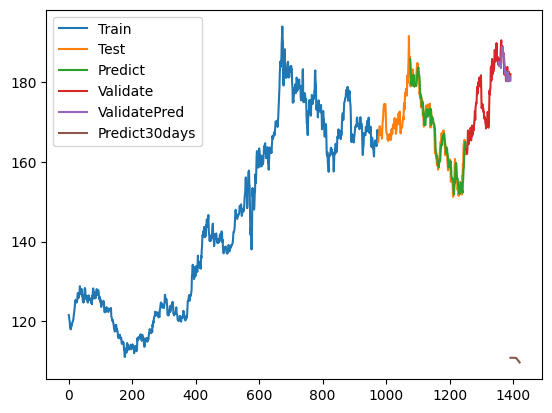

In [19]:
# 14.Plot
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()